## Twitter Sentiment Analysis: Apple vs. Google

### Problem Statement
In today's digital age, customer opinions on tech products are widely shared on social media platforms like Twitter. Understanding public sentiment towards brands like Apple and Google is crucial for businesses to assess customer satisfaction, improve marketing strategies, and address potential issues. 

This project aims to develop a Natural Language Processing (NLP) model that can automatically classify the sentiment of tweets about Apple and Google products as positive, negative, or neutral. By analyzing real-world social media data, this model will help derive valuable insights into consumer perceptions.

### Dataset Description
The dataset comes from CrowdFlower via data.world. It contains over 9,000 tweets about Apple and Google products, rated by human annotators as positive, negative, or neutral. The goal of this project is to build an NLP model to classify the sentiment of tweets based on their content.

### Project Overview
This project aims to:
- Preprocess and analyze the dataset.
- Build a binary classifier (positive vs. negative) as a proof of concept.
- Extend to a multiclass classifier by including neutral tweets.
- Evaluate different NLP models (Logistic Regression, LSTM, BERT).
- Interpret model results using SHAP.

### Import Necessary Libraries
To perform data analysis, visualization, and model training, we need to import essential Python libraries.

In [1]:
!pip install xgboost
!pip install transformers torch
!pip install --upgrade xgboost

# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.sparse import issparse
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_sample_weight

# Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Data Loading & Preprocessing

### 1.1 Understanding the dataset
Before building our NLP model, we first examine the dataset structure, identify missing values, and analyze sentiment label distributions.

### 1.2 Dataset Description
The dataset consists of 8,721 tweets with three columns:
- `tweet_text`: The text of the tweet.
- `emotion_in_tweet_is_directed_at`: The entity (if any) at which the emotion is directed (Apple, Google, etc.), with 5,552 missing values.
- `is_there_an_emotion_directed_at_a_brand_or_product`: Indicates whether an emotion is directed at a brand or product.

The dataset is entirely text-based, requiring preprocessing to handle missing values and prepare it for sentiment analysis.

In [3]:
# Load dataset
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')  # Update with actual file path
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# Display dataset information
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


None

In [5]:
# Check for missing values
display(df.isnull().sum())

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
# Display column names and data types
display(df.dtypes)

tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

### 1.3 Handling Missing Values
Handling missing values ensures data consistency and reliability before applying NLP models.

- The `emotion_in_tweet_is_directed_at` column has **5,552 missing values**, which are replaced with `"Unknown"` to retain data while acknowledging the uncertainty.
- The `tweet_text` column is critical for sentiment analysis, so rows where this field is missing are **dropped**.
- Other columns are analyzed, but no additional significant missing values require handling.

This step ensures that the dataset remains robust for sentiment classification while minimizing data loss.


In [7]:
# Handle missing values
df['emotion_in_tweet_is_directed_at'].fillna('Unknown', inplace=True)
df.dropna(subset=['tweet_text'], inplace=True)  # Dropping tweets with no text

C:\Users\USER\AppData\Local\Temp\ipykernel_26808\1543978109.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['emotion_in_tweet_is_directed_at'].fillna('Unknown', inplace=True)


### 1.4 Renaming Long Column/Row Names for Clarity
The sentiment column name is long and unclear. We rename it to "sentiment" for simplicity. We also changed a sentiment label to a shorter name,"No emotion" for clarity

In [8]:
# Rename column and sentiment categories
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)
df['sentiment'] = df['sentiment'].replace({'No emotion toward brand or product': 'No emotion'})

# 2. EDA (Exploratory Data Analysis)
Exploratory Data Analysis (EDA) is a crucial step in preparing the dataset for sentiment analysis.

- Helps us understand the dataset by exploring missing values, distributions, and patterns within the data. 
  - We analyze sentiment distribution, hashtag usage, and mentions to gain insights into tweet content.

### **2.1 Sentiment Distribution**
The following bar chart displays the count of tweets for each sentiment category. It will help us identify whether the dataset is balanced, or skewed toward a particular sentiment

C:\Users\USER\AppData\Local\Temp\ipykernel_26808\807677651.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


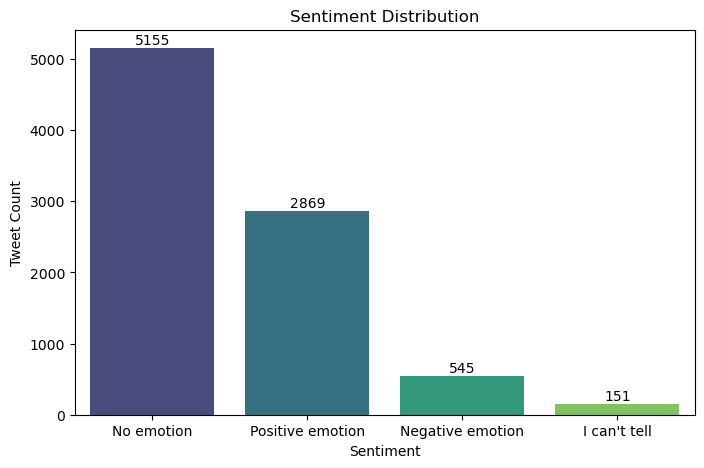

In [9]:
# Count the number of tweets for each sentiment category
sentiment_counts = df['sentiment'].value_counts()

# Set figure size for better visibility
plt.figure(figsize=(8,5))

# Create a bar plot to visualize the distribution of sentiment categories
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
# Add a title and labels for clarity
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
# Annotate bars with their respective values for better readability
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, str(v), ha='center')
plt.show()

#### 2.1.a Sentiment Distribution Analysis  
The sentiment distribution graph shows a significant imbalance in the dataset: 

- **"No emotion"** dominates with over **5,000 tweets**, indicating that most users do not express clear sentiment. 
- **"Positive emotion"** follows with close to **3,000 tweets**, suggesting a strong presence of favorable opinions.  
- **"Negative emotion"** is the least common, with a little over **500 tweets**, showing minimal negative feedback.
- A small number of tweets fall under **"I can't tell"**, reflecting sentiment uncertainty

This imbalance is crucial because skewed data can affect model performance, leading to biased predictions. The prevalence of neutral tweets may also impact the interpretability of sentiment trends. Handling this imbalance will be key in ensuring accurate sentiment classification.

### **2.2 Tweet Length Distribution**
This analysis shows the variation in tweet lengths, highlighting whether users tend to post shorter or longer tweets. It helps identify patterns in sentiment expression and tweet verbosity.

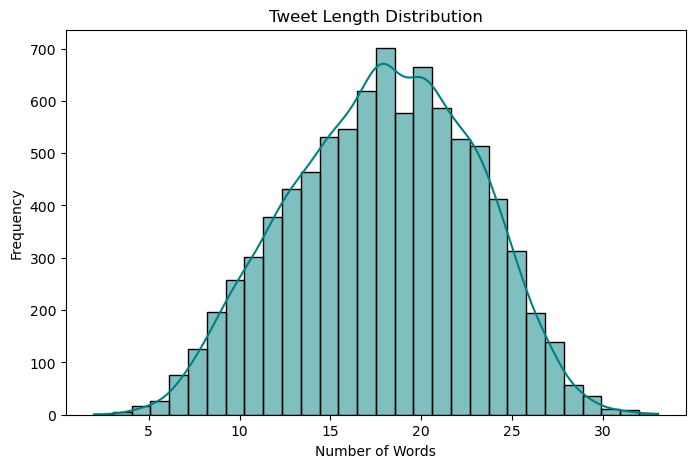

In [10]:
# Calculate tweet lengths
df['tweet_length'] = df['tweet_text'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.figure(figsize=(8,5))
sns.histplot(df['tweet_length'], bins=30, kde=True, color='teal')
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


#### 2.2.b Tweet Length Distribution Analysis
Most tweets range between 15-20 words, forming a near-normal distribution. This balance helps in sentiment analysis and preprocessing.

# 3. Tokenization & Feature Engineering
### **3.1 Tokenization**
Tokenization is a crucial step in NLP, where text is split into individual words (tokens). This helps in:
- Standardizing text representation
- Removing unnecessary punctuation
- Enabling further preprocessing like stopword removal and lemmatization 

Tokenizing before word frequency analysis ensures that we capture meaningful words rather than raw text.

In [11]:
# Define text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase for standardization
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)  # Tokenize text into words
    stopwords_list = set(stopwords.words('english')) - {'not', 'never'}  # Retain negation words
    
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word not in stopwords_list and word.isalpha()]
    
    # Apply lemmatization for better text normalization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Apply stemming as an additional normalization step
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 2]  # Remove rare words
    
    return tokens

In [12]:
# Apply preprocessing 
df['preprocessed_text'] = df['tweet_text'].apply(preprocess_text)# Tokenized version
df['IDF_text'] = df['preprocessed_text'].apply(lambda x: ' '.join(x))  # String version for TF-ID

### **3.2 Frequent Words by Sentiment Category**  
After tokenizing and cleaning the text, we analyze the most common words in each sentiment category. This helps identify key terms associated with positive, negative, and neutral tweets, providing insights into recurring themes within each sentiment group.


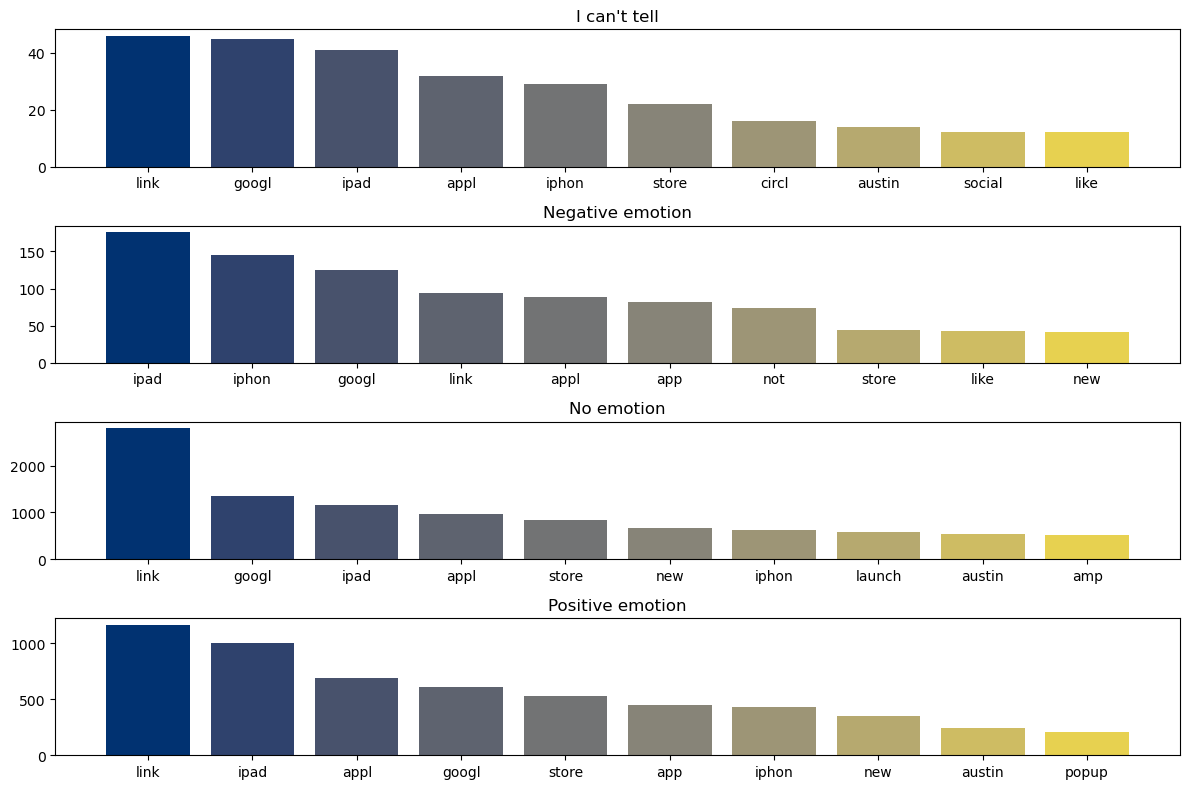

In [13]:
fig, axes = plt.subplots(nrows=len(df['sentiment'].unique()), figsize=(12, 2 * len(df['sentiment'].unique())))
for idx, (sentiment, sentiment_df) in enumerate(df.groupby('sentiment')):
    all_words = [word for text in sentiment_df['preprocessed_text'] for word in text]
    top_10 = pd.Series(all_words).value_counts()[:10]
    axes[idx].bar(top_10.index, top_10.values, color=sns.color_palette('cividis', n_colors=10))
    axes[idx].set_title(sentiment)
fig.tight_layout()
plt.show()


#### 3.2.b Analysis - Frequent Words by Sentiment Category
The bar charts show the most common words across different sentiment categories. Key observations:  

- **"Link"** appears frequently in all categories, suggesting a prevalence of shared URLs in tweets.  
- **"Google"**, **"Apple"**, **"iPad"**, and **"iPhone"** are common across sentiments, reflecting product discussions.  
- Negative sentiment tweets emphasize **"iPad"** and **"iPhone"**, possibly highlighting user concerns or complaints.  
- Positive sentiment tweets include **"launch"** and **"new"**, indicating excitement about new products.  

This analysis helps understand which words drive sentiment in Apple and Google-related discussions.


### **3.3 Hashtag & Mention Analysis**  
This section identifies the most frequently used hashtags and mentions, providing insights into trending topics and key influencers in Apple and Google-related discussions.  

**@mention** is likely a placeholder, not a real mention. Removing it helps reveal the actual most-mentioned accounts, making the insights clearer.

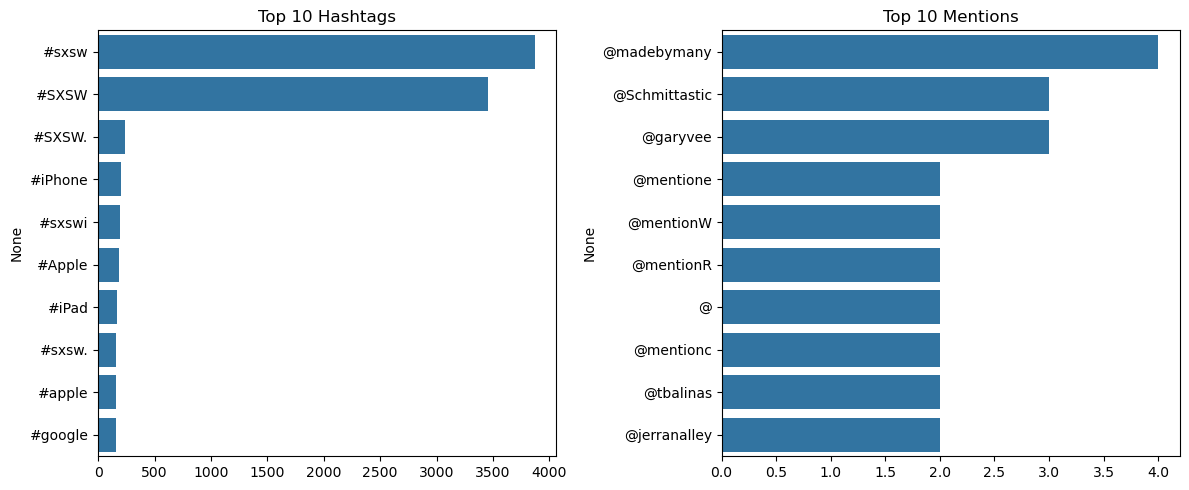

In [15]:
import itertools

# Extract hashtags and mentions
df['hashtags'] = df['tweet_text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
df['mentions'] = df['tweet_text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])

# Remove '@mention' placeholder from mentions
df['mentions'] = df['mentions'].apply(lambda x: [m for m in x if m.lower() != '@mention'] if isinstance(x, list) else x)

# Flatten lists
all_hashtags = list(itertools.chain(*df['hashtags']))
all_mentions = list(itertools.chain(*df['mentions']))

# Get top 10 hashtags & mentions
top_hashtags = pd.Series(all_hashtags).value_counts()[:10]
top_mentions = pd.Series(all_mentions).value_counts()[:10]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=top_hashtags.values, y=top_hashtags.index, ax=axes[0])
axes[0].set_title('Top 10 Hashtags')

sns.barplot(x=top_mentions.values, y=top_mentions.index, ax=axes[1])
axes[1].set_title('Top 10 Mentions')

plt.tight_layout()
plt.show()


#### 3.3.a Hashtag & Mention Analysis
The top hashtags are all about #SXSW, with a few mentions of #iPhone, #Apple, and #Google—tech is clearly a hot topic!

For mentions, after cleaning up the noisy @mention, we see @madebymany, @garyvee, and @Schmittastic leading, though overall mentions are pretty scattered. Might be worth refining the extraction for better insights!

### **3.4 Bigram & Trigram**
Finds the most frequent word pairs and triplets. This helps spot trending phrases and key discussion point.

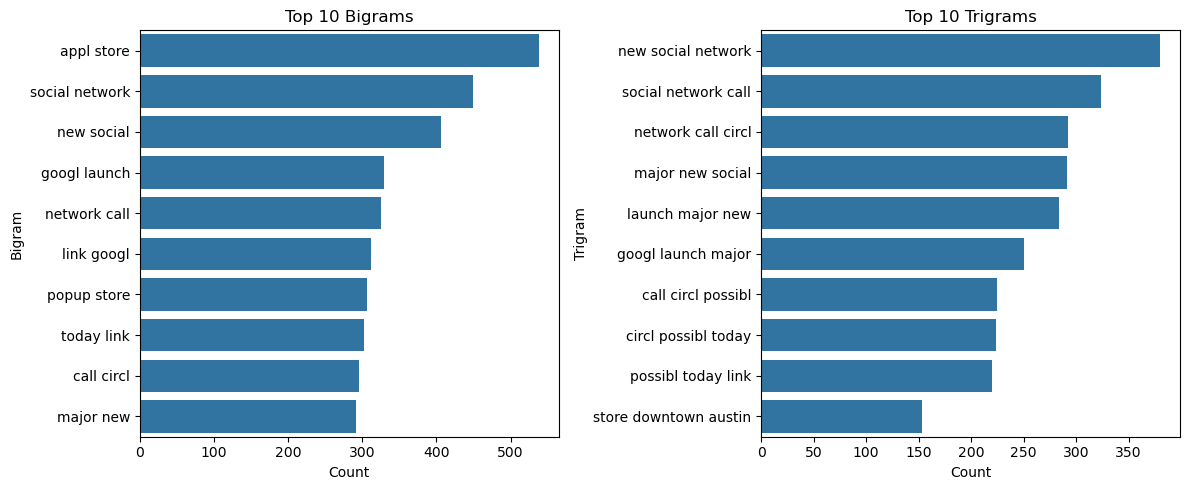

In [16]:
from collections import Counter
from itertools import islice
from nltk.util import ngrams

# Function to extract n-grams
def get_top_ngrams(corpus, n=2, top_k=10):
    tokens = [word for text in corpus for word in text]  # Flatten list
    n_grams = list(ngrams(tokens, n))
    return Counter(n_grams).most_common(top_k)

# Compute top bigrams and trigrams
bigrams = get_top_ngrams(df['preprocessed_text'], n=2, top_k=10)
trigrams = get_top_ngrams(df['preprocessed_text'], n=3, top_k=10)

# Convert to DataFrame for plotting
bigram_df = pd.DataFrame(bigrams, columns=['Bigram', 'Count'])
trigram_df = pd.DataFrame(trigrams, columns=['Trigram', 'Count'])

# Plot bigrams & trigrams
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(y=bigram_df['Bigram'].apply(lambda x: ' '.join(x)), x=bigram_df['Count'], ax=axes[0])
axes[0].set_title('Top 10 Bigrams')

sns.barplot(y=trigram_df['Trigram'].apply(lambda x: ' '.join(x)), x=trigram_df['Count'], ax=axes[1])
axes[1].set_title('Top 10 Trigrams')

plt.tight_layout()
plt.show()


#### 3.4.a Bigram & Trigram Analysis
The top bigrams highlight key topics like "Apple Store," "social network," and "Google launch", suggesting discussions around tech products and events. Trigrams like "new social network" and "network call circl" hint at trending themes in the conversation. Looks like a lot of buzz around product launches and networking.

### **3.5 Feature Extraction (TF-IDF Vectorization)**
Feature extraction is a critical step because machine learning models cannot process raw text. TF-IDF (Term Frequency-Inverse Document Frequency) helps by converting text into numerical values that represent word importance within tweets. This improves model accuracy by emphasizing relevant words while reducing the impact of common but unimportant words.

In [17]:
# Feature Extraction (TF-IDF Vectorization)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['IDF_text']).toarray()
y = df['sentiment'].map({'Positive emotion': 1, 'Negative emotion': 0, 'No emotion': 2, "I can't tell": 3})  # Encode labels

# 4. Modeling

### Overview
This section covers the modeling approach for classifying tweets about Apple and Google products as positive, negative, or neutral. We will explore multiple models using pipelines and hyperparameter tuning techniques like GridSearchCV and RandomizedSearchCV

### Model Selection
We will train and evaluate the following models:
- **Logistic Regression** (Baseline model)
- **Support Vector Machine (SVM)**
- **XGBoost** (Gradient boosting model for improved performance)
- **BERT (Transformer-based Model)**

### Splitting the data in preparation for modeling:

In [49]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Apply SMOTEENN to balance the dataset
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Train-Test Split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("Data balancing complete! Train-test split applied.")


Data balancing complete! Train-test split applied.


### **4.1 Machine Learning Pipeline**
We use `sklearn.pipeline.Pipeline` to automate feature transformation and model training.

In [51]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np

# Compute sample weights
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Compute class weights for XGBoost
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_weights_xgb = {cls: max(class_counts) / count for cls, count in zip(unique_classes, class_counts)}

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
    "Support Vector Machine": SVC(class_weight="balanced", probability=True),
    "XGBoost": XGBClassifier(objective="multi:softmax", 
                             num_class=len(unique_classes), 
                             tree_method="hist")
}


# Define TF-IDF outside loop
tfidf = TfidfVectorizer()

# Ensure X_train and X_test are strings
X_train = list(map(str, X_train))
X_test = list(map(str, X_test))

# Iterate through models and perform training
for name, model in models.items():
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('model', model)
    ])

    print(f"Training {name}...")
    
    if name in ["Logistic Regression", "Support Vector Machine"]:
        pipeline.fit(X_train, y_train, model__sample_weight=sample_weights)
    elif name == "XGBoost":
        model.fit(tfidf.fit_transform(X_train), y_train, sample_weight=sample_weights)  # XGBoost does not use Pipeline well

    print(f"{name} training complete.")


Training Logistic Regression...
Logistic Regression training complete.
Training Support Vector Machine...
Support Vector Machine training complete.
Training XGBoost...
XGBoost training complete.


### **4.2 Hyperparameter Tuning**

In [52]:
param_grid = {
    "Logistic Regression": {'model__C': [0.01, 0.1, 1, 10, 100]},  # More C values
    "Support Vector Machine": {'model__C': [0.1, 1, 10, 100], 'model__kernel': ['linear', 'rbf', 'poly']},  # More kernels
    "XGBoost": {'model__n_estimators': [50, 100, 200], 'model__max_depth': [3, 5, 7]},  # More depth values
}

best_models = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])
    # Adjust `n_iter` based on the number of hyperparameter combinations
    n_iter_values = {
        "Logistic Regression": 5,  # All possible combinations tested
        "Support Vector Machine": 10,  # More coverage
        "XGBoost": 7  # More coverage but not too slow
    }
    
    search = RandomizedSearchCV(pipeline, param_grid[name], n_iter=n_iter_values[name], cv=3, scoring='accuracy', n_jobs=-1, error_score="raise")
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"Best parameters for {name}: {search.best_params_}")

Best parameters for Logistic Regression: {'model__C': 1}
Best parameters for Support Vector Machine: {'model__kernel': 'linear', 'model__C': 1}
Best parameters for XGBoost: {'model__n_estimators': 100, 'model__max_depth': 7}


### Model Evaluation

In [53]:
from sklearn.preprocessing import label_binarize
# Get unique classes in y_train (to ensure consistency)
unique_classes = sorted(set(y_train))

# Binarize labels for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=unique_classes)  # Adjust class labels as per your dataset

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Model Performance:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if name == "XGBoost":
        if hasattr(model, "decision_function"):  # Check if model supports decision_function
            y_scores = model.decision_function(X_test)
        else:
            y_scores = model.predict_proba(X_test)  # Use predict_proba for models without decision_function

        if len(unique_classes) > 2:
            print("ROC-AUC Score:", roc_auc_score(y_test_binarized, y_scores, multi_class="ovr"))
        else:
            print("ROC-AUC Score:", roc_auc_score(y_test, y_scores[:, 1]))  # For binary classification



Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.31      1.00      0.47       977
           1       1.00      0.00      0.00       535
           2       1.00      0.00      0.00       654
           3       0.00      0.00      0.00      1001

    accuracy                           0.31      3167
   macro avg       0.58      0.25      0.12      3167
weighted avg       0.47      0.31      0.15      3167

Confusion Matrix:
[[ 977    0    0    0]
 [ 534    1    0    0]
 [ 653    0    1    0]
 [1001    0    0    0]]


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Support Vector Machine Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       977
           1       1.00      0.00      0.00       535
           2       1.00      0.00      0.00       654
           3       0.32      1.00      0.48      1001

    accuracy                           0.32      3167
   macro avg       0.58      0.25      0.12      3167
weighted avg       0.48      0.32      0.15      3167

Confusion Matrix:
[[   0    0    0  977]
 [   0    1    0  534]
 [   0    0    1  653]
 [   0    0    0 1001]]

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       977
           1       1.00      0.00      0.00       535
           2       0.00      0.00      0.00       654
           3       0.32      1.00      0.48      1001

    accuracy                           0.32      3167
   macro avg       0.33      0.25      0.12      3167
wei

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\s

### Deep Learning Approach (BERT)

In [251]:
# Load tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = bert_tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        return {**encoding, 'labels': torch.tensor(self.labels[idx])}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [252]:
# Create dataset and dataloader
train_dataset = TweetDataset(X_train, y_train)
test_dataset = TweetDataset(X_test, y_test)

training_args = TrainingArguments(output_dir='./results', evaluation_strategy='epoch', per_device_train_batch_size=8, per_device_eval_batch_size=8, num_train_epochs=3, weight_decay=0.01)

trainer = Trainer(model=bert_model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)

trainer.train()

c:\Users\USER\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`